In [81]:
# Pytorch package
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms


from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import os
import numpy as np
from plotly import graph_objects as go
import plotly.express as px
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import math


In [82]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


## Hyperparameter List

In [96]:
TARRGET_SIZE = (224, 224) # what size we want to reshape to for data augmentation (see below)
BATCH_SIZE = 32

## Data Exploration, Visualization, Pre-Processing



In [97]:
def load_dataset_dataframes():
  test_array = []
  train_array = []

  for category in os.listdir('Testing'):
    for file in os.listdir(os.path.join('Testing', category)):
        # Ensure we're only adding image files
        file_path = os.path.join('Testing', category, file)
        if os.path.isfile(file_path) and file.lower().endswith(('.png', '.jpg', '.jpeg')):
          test_array.append([file_path, category])

  test_dataframe = pd.DataFrame(test_array, columns=['file_path', 'label'])
          
  for category in os.listdir('Training'):
    for file in os.listdir(os.path.join('Training', category)):
        # Ensure we're only adding image files
        file_path = os.path.join('Training', category, file)
        if os.path.isfile(file_path) and file.lower().endswith(('.png', '.jpg', '.jpeg')):
          train_array.append([file_path, category])
  
  train_dataframe = pd.DataFrame(train_array, columns=['file_path', 'label'])
        
  return test_dataframe, train_dataframe

def load_image(image_path):
  image = Image.open(image_path)
  image = image.resize((64, 64))
  image = np.array(image)
  image = torch.from_numpy(image).float()
  return image

### Exploring the Data

In [98]:
# Display a couple random samples (re-run to load a new image)
train_dataframe, test_dataframe = load_dataset_dataframes()
random_image_path = np.random.choice(test_dataframe['file_path'])
random_image = load_image(random_image_path)
display(random_image_path)
px.imshow(random_image, color_continuous_scale='gray').show()

'Training/meningioma/Tr-me_1318.jpg'

In [99]:
# Plot the dataset
def plot_dataset(dataset_type):

    base_directory = os.getcwd()
    categories = os.listdir(base_directory+'/'+dataset_type)

    path = os.path.join(base_directory, dataset_type)
    counts = [len(os.listdir(os.path.join(path, cat))) for cat in categories]

    plt.bar(categories, counts, color = ['navy', 'teal', 'darkorange', 'crimson'])
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"{dataset_type.capitalize()} Set Distribution")
    plt.show()


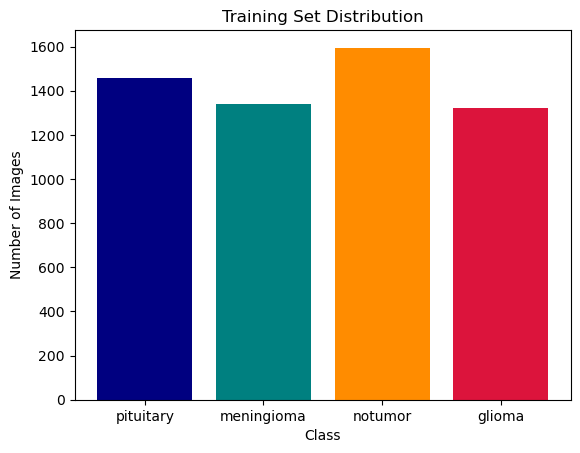

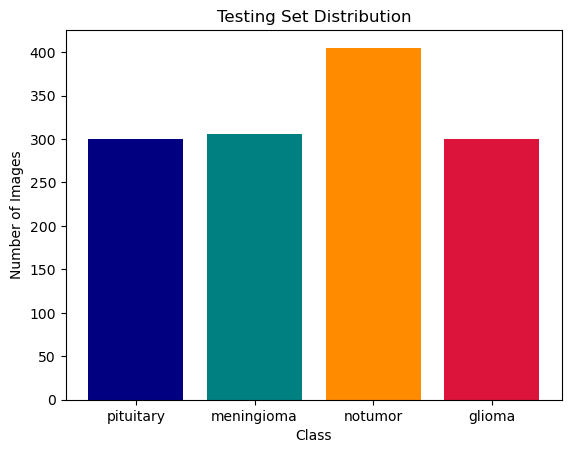

In [100]:
plot_dataset('Training')
plot_dataset('Testing')

### Data Preprocessing

In [101]:
# Important!!!! Turn categories into numbers for use within neural networks

label_map = {
    'notumor': 0,        
    'glioma': 1,         
    'meningioma': 2,     
    'pituitary': 3       
}

train_dataframe['label'] = train_dataframe['label'].map(label_map)
test_dataframe['label'] = test_dataframe['label'].map(label_map)

In [102]:
print(train_dataframe)

                               file_path  label
0     Testing/pituitary/Te-piTr_0002.jpg      3
1       Testing/pituitary/Te-pi_0101.jpg      3
2       Testing/pituitary/Te-pi_0218.jpg      3
3       Testing/pituitary/Te-pi_0138.jpg      3
4       Testing/pituitary/Te-pi_0177.jpg      3
...                                  ...    ...
1306       Testing/glioma/Te-gl_0216.jpg      1
1307       Testing/glioma/Te-gl_0257.jpg      1
1308       Testing/glioma/Te-gl_0194.jpg      1
1309       Testing/glioma/Te-gl_0050.jpg      1
1310       Testing/glioma/Te-gl_0221.jpg      1

[1311 rows x 2 columns]


### Splitting into train, validation, and test sets

In [109]:
def split_test_validation(data, ratio=0.50):

    # if the list isn't divisble by 50%...
    split_index_test = math.ceil(len(data) * ratio)


    test_df = data[:split_index_test]
    val_df = data[split_index_test:]

    return test_df, val_df





test_df_split, val_df_split = split_test_validation(test_dataframe, ratio=0.5)
# Reset indices for consistency (instead of index starting from halfway, it'll start from 0)
test_df_split = test_df_split.reset_index(drop=True)
val_df_split = val_df_split.reset_index(drop=True)


print(test_dataframe.size)
print(test_df_split.size)
print(val_df_split.size)

11424
5712
5712


In [110]:
## Making sure everything makes sense
print(test_dataframe.size)
print(test_df_split.size)
print(val_df_split.size)

11424
5712
5712


### Create Class ImageDataset
##### Inherits from Pytorch's "Dataset" class, can be used to load Data

In [111]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert('RGB')  

        if self.transform:
            img = self.transform(img)
            
        return img, label

### Data Augmentation

In [112]:
train_transform = transforms.Compose([

   transforms.Resize(TARRGET_SIZE),
   transforms.RandomHorizontalFlip(),
   transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
   transforms.ColorJitter(brightness=(0.8, 1.2)),
   transforms.RandomRotation(10),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [114]:
# Apply Data Augmentation

final_train_dataset = ImageDataset(train_dataframe, transform=train_transform)
final_val_dataset = ImageDataset(val_df_split, transform=test_transform)
final_test_dataset = ImageDataset(test_df_split, transform=test_transform)


# DataLoader

train_loader = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(final_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(final_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## (Model 1) Custom CNN

## (Model 2) ResNet

## Gradient Visualization